## HW3-Q1

## K-means

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2

In [2]:
#read data
with open('cluster.txt','r') as f:
    lines=f.readlines()
pattern=re.compile(r'^-?\d+(\.\d+)?\s+-?\d+(\.\d+)?\s+[a-zA-Z]+(_[a-zA-Z]+)*$')
new_lines=[i for i in lines if pattern.match(i.strip())]
with open('new_lines.txt','w') as f:
    f.writelines(new_lines)
pairs=pd.read_table('new_lines.txt',sep=' ',header=None,names=['x','y','label'])
pairs_3=pairs.to_numpy()

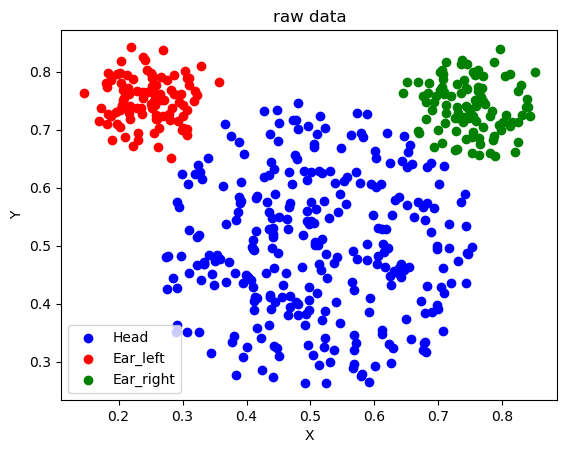

In [3]:
#draw raw data
plt.figure()
idx=np.where(pairs_3[:,2]=='Head')[0]
plt.scatter(pairs_3[idx,0],pairs_3[idx,1],color='blue')
idx=np.where(pairs_3[:,2]=='Ear_left')[0]
plt.scatter(pairs_3[idx,0],pairs_3[idx,1],color='red')
idx=np.where(pairs_3[:,2]=='Ear_right')[0]
plt.scatter(pairs_3[idx,0],pairs_3[idx,1],color='green')
plt.legend(['Head','Ear_left','Ear_right'])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('raw data')
plt.show()

In [4]:
#kmean
K=3
pairs_2=pairs_3[:,:2]
pairs_2=pairs_2.astype(float)
centroid,label=kmeans2(pairs_2,K,minit='points')
sorted_centroid=centroid[centroid[:,0].argsort()]
sorted_centroid[[1,2]]=sorted_centroid[[2,1]]
sorted_label=np.zeros_like(label)
for i in range(len(label)):
    for j in range(3):
        if centroid[label[i],0]==sorted_centroid[j,0]:
            sorted_label[i]=j
#print(sorted_label)

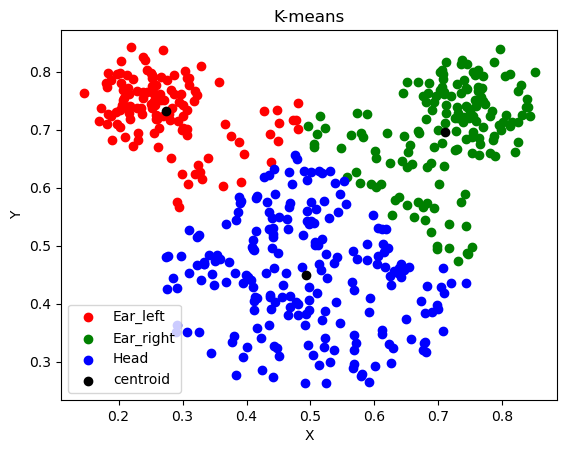

In [5]:
color_dic={0:'red',1:'green',2:'blue'}
plt.figure()
for i in range(3):
    idx=np.where(sorted_label==i)[0]
    plt.scatter(pairs_2[idx,0],pairs_2[idx,1],color=color_dic[i])
plt.scatter(centroid[:,0],centroid[:,1],color='black')
plt.legend(['Ear_left','Ear_right','Head','centroid'])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('K-means')
plt.show()

In [6]:
#confusion matrix
confusion_matrix = pd.crosstab(pairs_3[:,2],sorted_label,rownames=['Actual'],colnames=['Predicted'])
print("Confusion Matrix")
print("(0:Ear_left, 1:Ear_right, 2:Head)")
print(confusion_matrix)

Confusion Matrix
(0:Ear_left, 1:Ear_right, 2:Head)
Predicted    0    1    2
Actual                  
Ear_left   100    0    0
Ear_right    0  100    0
Head        25   54  211


## GMM

In [7]:
def draw_label_scater(X,label,title):
    color_dic={0:'red',1:'green',2:'blue'}
    plt.figure()
    for i in range(3):
        idx=np.where(label==i)[0]
        plt.scatter(X[idx,0],X[idx,1],color=color_dic[i])
    plt.legend(['Ear_left','Ear_right','Head'])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.show()

In [8]:
#PDF
def jointed_gaussian_pdf(X,mu,sigma):
    N=len(X)
    D=len(X[0])
    sigma_inv=np.linalg.inv(sigma)
    sigma_det=np.linalg.det(sigma)
    lowwer=1/(np.sqrt(((2*np.pi)**D)*sigma_det))
    pdf=np.zeros(N)
    for i in range(N):
        diff=X[i]-mu
        exponent=-0.5*np.dot(diff.T,np.dot(sigma_inv,diff))
        pdf[i]=lowwer*np.exp(exponent)
    return pdf

In [13]:
#GMM
def gmm(X,K,gamma,pis,mus,sigmas,max_iter=100,tol=1e-4):
    N=len(X)
    D=len(X[0])
    ll_old=0#-np.inf    #negative log-likelihood
    new_label=np.zeros_like(label)
    for iter in range(max_iter):
        #E-step
        for k in range(K):
            gamma[:,k]=pis[k]*jointed_gaussian_pdf(X,mus[k],sigmas[k])
        gamma/=np.sum(gamma,axis=1,keepdims=True)
        print(gamma)
        #for k in range(K):
        #    gamma[:,k]/=sum(gamma[:,k])
        
        # M-step
        for k in range(K):
            pis[k]=sum(gamma[:,k])/N
            for d in range(D):
                mus[k,d]=sum(gamma[:,k]*X[:,d])/sum(gamma[:,k])
            diff=X-mus[k]
            sigmas[k]=np.dot(gamma[:,k]*diff.T,diff)/sum(gamma[:,k])
        
        #update new_label and draw first four iterations
        for n in range(N):
            new_label[n]=np.argmax(gamma[n])
        if iter<4:
            draw_label_scater(pairs_2,new_label,f"GMM(iteration:{iter+1})")
            
        #negative log-likelihood
        ll_new=0
        for k in range(K):
            ll_new+=pis[k]*jointed_gaussian_pdf(X,mus[k],sigmas[k])
        ll_new=sum(np.log(ll_new))
        if abs(ll_new-ll_old)<tol:
            draw_label_scater(pairs_2,new_label,f"Final result of GMM(iteration:{iter+1})")
            break
        ll_old=ll_new
    return new_label

[[3.97145347e-07 3.96428784e-04 9.99603174e-01]
 [7.74283252e-06 2.67884446e-01 7.32107811e-01]
 [7.67642017e-01 2.09323382e-02 2.11425645e-01]
 ...
 [3.98530668e-13 9.99887176e-01 1.12824280e-04]
 [2.32962923e-11 9.99440475e-01 5.59525124e-04]
 [1.25709033e-09 9.99775315e-01 2.24683911e-04]]


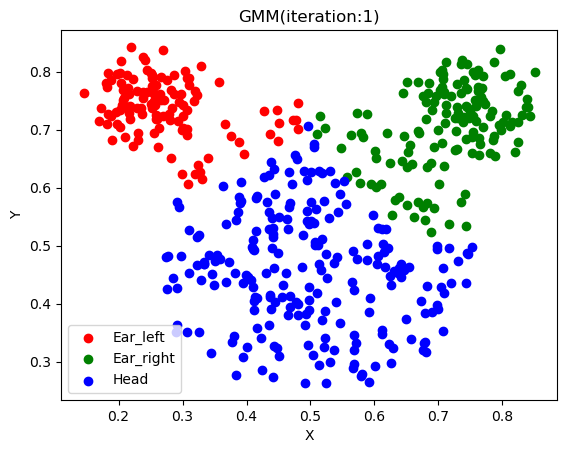

[[2.06772183e-08 5.44279065e-04 9.99455700e-01]
 [2.67531821e-06 2.02546603e-01 7.97450721e-01]
 [6.13364723e-01 1.46228411e-02 3.72012436e-01]
 ...
 [1.18541536e-13 9.99367580e-01 6.32420386e-04]
 [1.09310968e-11 9.97575761e-01 2.42423872e-03]
 [3.76559288e-10 9.98912609e-01 1.08739014e-03]]


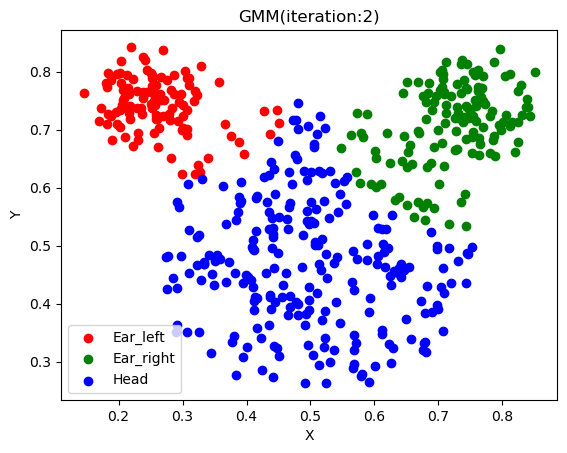

[[7.63794215e-10 2.00699371e-04 9.99799300e-01]
 [9.25386901e-08 1.18600069e-01 8.81399839e-01]
 [3.76028365e-01 9.47378139e-03 6.14497853e-01]
 ...
 [1.27132937e-15 9.98609175e-01 1.39082495e-03]
 [1.65688097e-13 9.95183576e-01 4.81642439e-03]
 [2.05433722e-11 9.97681293e-01 2.31870744e-03]]


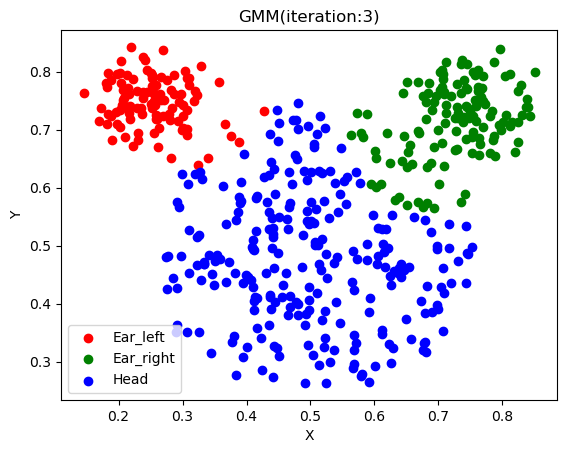

[[1.23288047e-11 3.39060029e-05 9.99966094e-01]
 [2.10129582e-10 5.60313330e-02 9.43968667e-01]
 [1.03729022e-01 4.72464757e-03 8.91546330e-01]
 ...
 [5.63104586e-20 9.97631671e-01 2.36832904e-03]
 [1.51291864e-17 9.92344154e-01 7.65584620e-03]
 [3.59045586e-14 9.96032274e-01 3.96772636e-03]]


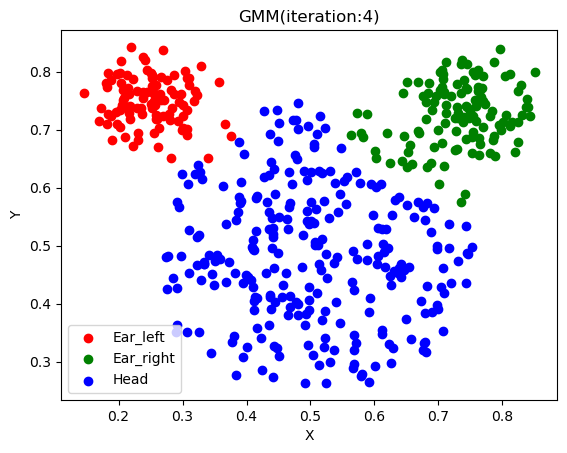

[[3.91973344e-14 2.75728619e-06 9.99997243e-01]
 [1.29289457e-14 2.18100439e-02 9.78189956e-01]
 [9.05989413e-03 1.40531192e-03 9.89534794e-01]
 ...
 [3.42362443e-27 9.96548708e-01 3.45129246e-03]
 [2.90073678e-24 9.89457817e-01 1.05421828e-02]
 [9.99135546e-19 9.94184312e-01 5.81568837e-03]]
[[4.36168064e-17 1.09438096e-07 9.99999891e-01]
 [5.58794532e-19 6.94885937e-03 9.93051141e-01]
 [8.85451414e-04 3.13029586e-04 9.98801519e-01]
 ...
 [1.66364280e-33 9.95519616e-01 4.48038404e-03]
 [2.73435842e-30 9.86933064e-01 1.30669361e-02]
 [1.37046592e-22 9.92549578e-01 7.45042224e-03]]
[[2.20042954e-19 2.67512222e-09 9.99999997e-01]
 [7.74803127e-22 1.88937326e-03 9.98110627e-01]
 [2.33586066e-04 6.74043869e-05 9.99699010e-01]
 ...
 [9.51436375e-37 9.94540842e-01 5.45915763e-03]
 [1.67771354e-33 9.84642300e-01 1.53576996e-02]
 [1.77490735e-24 9.91125579e-01 8.87442123e-03]]
[[1.56574292e-20 6.10933552e-11 1.00000000e+00]
 [3.50929581e-23 4.97609174e-04 9.99502391e-01]
 [1.26777834e-04 1.608

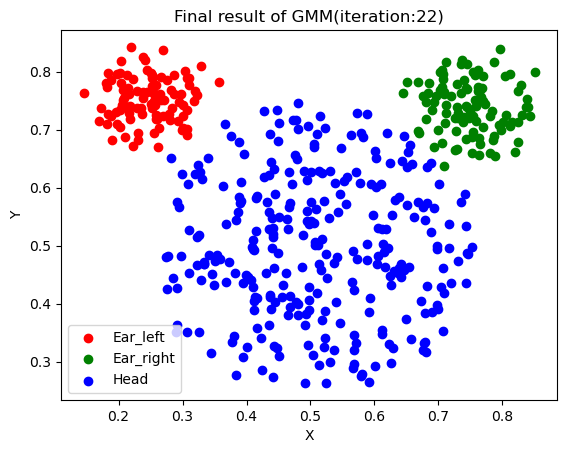

In [14]:
#one-hot
one_hot=np.zeros((len(pairs_3),K))
for i in range(len(sorted_label)):
    one_hot[i,sorted_label[i]]=1
#print(one_hot)

cluster_means=np.zeros((K,2))   #mu
cluster_covs=np.zeros((K,2,2))  #sigma
cluster_weights=np.zeros((K))   #pi
for k in range(K):
    cluster_weights[k]=sum(one_hot[:,k])/len(pairs_3)
    cluster_means[k,0]=sum(one_hot[:,k]*pairs_2[:,0])/sum(one_hot[:,k]) #x_mean
    cluster_means[k,1]=sum(one_hot[:,k]*pairs_2[:,1])/sum(one_hot[:,k]) #y_mean
    diff=pairs_2-cluster_means[k]
    cluster_covs[k,0,0]=sum(one_hot[:,k]*(diff[:,0]**2))/sum(one_hot[:,k])  #var(x)
    cluster_covs[k,1,1]=sum(one_hot[:,k]*(diff[:,1]**2))/sum(one_hot[:,k])  #var(y)
    cluster_covs[k,0,1]=cluster_covs[k,1,0]=sum(one_hot[:,k]*diff[:,0]*diff[:,1])/sum(one_hot[:,k]) #cov(x,y)
    
new_label=gmm(pairs_2,K,one_hot,cluster_weights,cluster_means,cluster_covs)

In [11]:
#confusion matrix
confusion_matrix = pd.crosstab(pairs_3[:,2],new_label,rownames=['Actual'],colnames=['Predicted'])
print("Confusion Matrix")
print("(0:Ear_left, 1:Ear_right, 2:Head)")
print(confusion_matrix)

Confusion Matrix
(0:Ear_left, 1:Ear_right, 2:Head)
Predicted   0    1    2
Actual                 
Ear_left   99    0    1
Ear_right   0  100    0
Head        0    1  289


### Comment

#### different
- K-means based purely on distance, so some "Head" points may be misclassified as "Ear_left" or "Ear_right" if thay are closer to those clusters.
- GMM can handle more complex situation, becase it consider both the mean and the covarance matrix of each cluster, allowing for clusters with different shapes and sizes.
#### perform
- In this problem, I think GMM performs better. GMM takes into account the variations in size and shape of different cluster.
- From the confusion matrices of two methods, we can see that the result of GMM are closer to the true labels compared to K-means.
- When clusters have the same shape and size, K-means may perform well and it computationally faster than GMM.